<a href="https://colab.research.google.com/github/Amarantine-xiv/Amas-FF14-Combat-Sim/blob/main/DotProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/content
fatal: destination path 'Amas-FF14-Combat-Sim' already exists and is not an empty directory.
/content/Amas-FF14-Combat-Sim
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), 114.34 KiB | 2.79 MiB/s, done.
From https://github.com/Amarantine-xiv/Amas-FF14-Combat-Sim
   510280e..99ace7b  main       -> origin/main
Updating 510280e..99ace7b
Fast-forward
 DotProcessing.ipynb | 1143 +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
 1 file changed, 1143 insertions(+)
 create mode 100644 DotProcessing.ipynb
Time taken: 2.29006290435791
Results: 
Average DPS: 14469.33
Percentile 25: 14223.20
Percentile 50: 14457.03
Percentile 75: 14702.40
Percentile 95: 15067.31
Percentile 99: 15326.63

Average Damage: 506426.59
Percentile 25: 497812.00
Percentile 50: 505996.00
Percentile 75: 514584.00
Percentile 

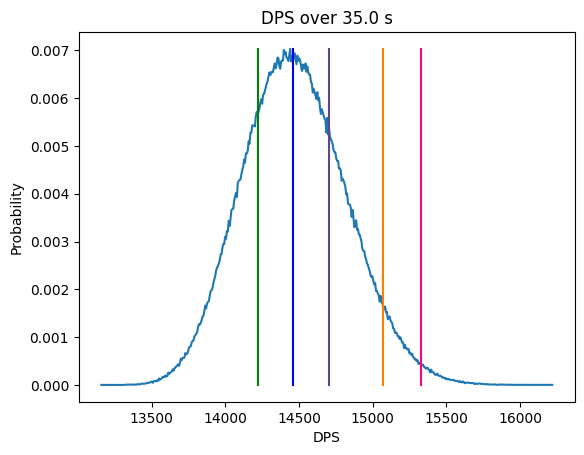

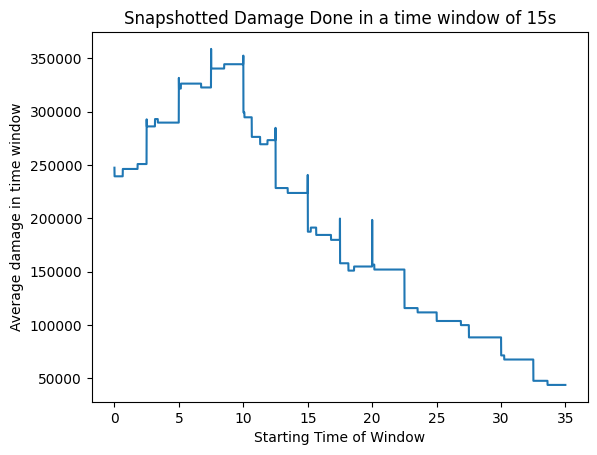

---Times (in ms) when skills get used:---
       0:               Tomahawk
     650:              Infuriate
     800:          Arcane Circle
    2500:            Heavy Swing
    5000:                   Maim
    5650:       Grade 8 Tincture
    6280:               Embolden
    6300:        Chain Stratagem
    7100:          Battle Litany
    7500:            Storm's Eye
    8150:          Inner Release
   10000:            Inner Chaos
   10650:               Upheaval
   11300:              Onslaught
   12500:            Primal Rend
   15000:            Inner Chaos
   15650:              Onslaught
   17500:            Fell Cleave
   18150:              Onslaught
   20000:            Fell Cleave
   22500:            Fell Cleave
   25000:            Heavy Swing
   27500:                   Maim
   30000:           Storm's Path
   32500:            Fell Cleave
   35000:            Inner Chaos


---Times (in ms) when damage lands:---
time:      0.0, name:                   Auto, expected_dama

In [1]:
#@title Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dataclasses
import functools
import requests
import pprint
import re
import copy
import math
import logging

from collections import namedtuple
from google.colab import userdata
from typing import *

GITHUB_PTA = userdata.get('GITHUB_PTA')
if not GITHUB_PTA:
  raise Exception(f"Please set Github Public Access Token (GITHUB_PTA) secret.")

# Ensure FFLOGS values are set when using this. Please set
# as secrets and do not use them in plaintext.
if not (userdata.get("FFLOGS_CLIENT_ID") or userdata.get("FFLOGS_CLIENT_SECRET")):
  raise Exception(f"Please set FFLOGs tokens to access logs. https://www.fflogs.com/api/clients/")

# TODO: move a lot of the implementation into python files on git
# So it can also just be added onto drive

# Pip req imports
!pip install coreapi==2.3.3 python-graphql-client==0.4.3
import coreapi
import python_graphql_client

%cd /content
!git clone https://"$GITHUB_PTA"@github.com/Amarantine-xiv/Amas-FF14-Combat-Sim
%cd /content/Amas-FF14-Combat-Sim
!git pull

%run '/content/Amas-FF14-Combat-Sim/CoreSimulator.ipynb'

In [2]:
#@title Custom FFLOGs constants
"""Defines and documents all custom columns in the data."""

# Not custom, but used a lot so recorded
ABILITY_ID = "abilityGameID"
TYPE = "type"
CAST = "cast"
DAMAGE = "damage"
APPLY_BUFF = "applybuff"
APPLY_DEBUFF = "applydebuff"
REFRESH_BUFF = "refreshbuff"
REFRESH_DEBUFF = "refreshdebuff"
REMOVE_BUFF = "removebuff"
REMOVE_DEBUFF = "removedebuff"
PREPARE = "calculateddamage"

# Human readable name for abilities
ABILITY_NAME = "ability_name"

# Human readable source name for actors
SOURCE_NAME = "source_name"
SOURCE_TYPE = "source_type"
SOURCE_SUBTYPE = "source_subtype"
SOURCE_PET_ACTOR = "source_pet_actor"
SOURCE_ID = "sourceID"

# Human readable target name for actors
TARGET_NAME = "target_name"
TARGET_TYPE = "target_type"
TARGET_SUBTYPE = "target_subtype"
TARGET_PET_ACTOR = "target_pet_actor"
TARGET_ID = "targetID"

# Fight time, based on lb update tick to reset gauge
FIGHT_TIME = "fight_time"

# Bonus percent, estimate the value of combos
# 1 - basePotency/bonusPotency = bonusPercent
BONUS_PERCENT = "bonusPercent"
AMOUNT = "amount"
LOG_DAMAGE = "unmitigatedAmount"  # amount column is affected by overkill
LOG_HIT_TYPE = "hitType"
LOG_DHIT = "directHit"
LOG_MULTIPLIER = "multiplier"

# Replaced names
CRIT = "crit"
DHIT = "direct_hit"

# Special name added in for an assumed prepull apply
ESTIMATED_APPLY_BUFF = "estimatedapplybuff"

# Special name for "correct" card
CARD_MATCHES_JOB = "card_matches_job"

# Mappings (target_subtype)
JOB = "Job"

# Breaking melee vs ranged in seperate mapping
TARGET_SUBTYPE_TO_JOB_MELEE = {
    "DarkKnight": "DRK",
    "Gunbreaker": "GNB",
    "Paladin": "PLD",
    "Warrior": "WAR",
    "Ninja": "NIN",
    "Samurai": "SAM",
    "Reaper": "RPR",
    "Monk": "MNK",
    "Dragoon": "DRG",
}

TARGET_SUBTYPE_TO_JOB_RANGED = {
    "Dancer": "DNC",
    "Bard": "BRD",
    "Machinist": "MCH",
    "RedMage": "RDM",
    "BlackMage": "BLM",
    "Summoner": "SMN",
    "Astrologian": "AST",
    "Scholar": "SCH",
    "Sage": "SGE",
    "WhiteMage": "WHM",
}

TARGET_SUBTYPE_TO_JOB = {
    **TARGET_SUBTYPE_TO_JOB_MELEE,
    **TARGET_SUBTYPE_TO_JOB_RANGED,
}


In [3]:
#@title EventInfo, SnapshotAndApplicationInfo, FightProcessingUtils

# NOTE: some of this code is copied from general logs processing, so it is a
# bit more general than it needs to be.

class EventInfo(namedtuple('EventInfo', [TYPE, 'timestamp', 'source_class', SOURCE_NAME, TARGET_NAME, 'skill_name', 'log_damage', 'direct_hit', 'critical_hit', 'bonus_percent', 'pet_name'])):
  def __key(self):
    return (self.timestamp, self.skill_name, self.pet_name)

  def __eq__(self, other):
    if isinstance(other, EventInfo):
      return self.__key() == other.__key()

  def __hash__(self):
    return hash(self.__key())

class SnapshotAndApplicationInfo(namedtuple('SnapshotAndDamageInfo', ['snapshot_time',
                                                                      'application_time',
                                                                      'source_class',
                                                                      'skill_name',
                                                                      'log_damage',
                                                                      'direct_hit',
                                                                      'critical_hit',
                                                                      'bonus_percent',
                                                                      'pet_name'])):
  pass


class FightProcessingUtils():
  def __merge_snapshots_and_applications(snapshots, applications):
    curr_snapshot_idx = 0
    next_snapshot_idx = 1
    res = []

    for curr_application in applications:
      next_snapshot_time = snapshots[next_snapshot_idx].timestamp if next_snapshot_idx < len(snapshots) else math.inf
      while curr_application.timestamp > next_snapshot_time:
        curr_snapshot_idx += 1
        next_snapshot_idx += 1
        if next_snapshot_idx >= len(snapshots):
          next_snapshot_time = math.inf
          break
        else:
          next_snapshot_time = snapshots[next_snapshot_idx].timestamp

      snapshot_and_application_info = SnapshotAndApplicationInfo(snapshot_time= snapshots[curr_snapshot_idx].timestamp,
                                                                                application_time= curr_application.timestamp,
                                                                                skill_name = curr_application.skill_name,
                                                                                source_class = curr_application.source_class,
                                                                                log_damage = curr_application.log_damage,
                                                                                direct_hit = curr_application.direct_hit,
                                                                                critical_hit = curr_application.critical_hit,
                                                                                bonus_percent = curr_application.bonus_percent,
                                                                                pet_name = curr_application.pet_name)
      res.append(snapshot_and_application_info)
    return res

  def merge_snapshots_and_applications(snapshots, applications):
    snapshots_dict = {}
    applications_dict = {}
    for snapshot in snapshots:
      if snapshot.skill_name not in snapshots_dict:
        snapshots_dict[snapshot.skill_name] = []
      snapshots_dict[snapshot.skill_name].append(snapshot)

    for application in applications:
      if application.skill_name not in applications_dict:
        applications_dict[application.skill_name] = []
      applications_dict[application.skill_name].append(application)

    # Remap names here to line up, if needed
    res = {}
    for key in applications_dict.keys():
      if key in snapshots_dict.keys():
        res[key] = FightProcessingUtils.__merge_snapshots_and_applications(snapshots_dict[key], applications_dict[key])
      else:
        print('Skill not found in snapshots: {}'.format(key))
      # verify this is not a bug if skill is not in snapshot?
    return res

  @staticmethod
  def __get_data_for_event_types(data, ignore_pets):
    if ignore_pets and (data.get('pet_name', None) is not None):
      return None
    critical_hit = False
    if 'hitType' in data.keys():
      critical_hit = True if data['hitType'] == 2 else False #wtf man?

    info = EventInfo(type=data[TYPE],
                     timestamp = data['timestamp'],
                     source_class = data[SOURCE_SUBTYPE],
                     source_name = data[SOURCE_NAME],
                     target_name = data[TARGET_NAME],
                     skill_name = data[ABILITY_NAME],
                     log_damage = data.get('amount', None),
                     direct_hit = data.get('directHit', False),
                     critical_hit = critical_hit,
                     bonus_percent=data.get('bonusPercent', None),
                     pet_name = data.get('pet_name', None))
    return info

  @staticmethod
  def get_data_for_event_types(event_data, event_types, ignore_pets=False):
    # Output values of dicts are guaranteed to be sorted by timestamp.
    # event_types is processed in priority order
    res = {}
    for event_type in event_types:
      for i in range(0, len(event_data)):
        data = event_data[i]
        if data['type'] != event_type:
          continue

        player_name = data['source_name']    # check if player is target???
        if player_name not in res.keys():
          res[player_name] = []
        info = FightProcessingUtils.__get_data_for_event_types(data, ignore_pets)
        if info is not None and info not in res[player_name]:
          res[player_name].append(info)

      for _, tmp in res.items():
        tmp.sort(key= lambda x: x.timestamp)
    return res

    # def remap_skill_names(e


In [4]:
#@title FFLOGS Api

def get_auth_token() -> str:
    """Fetches an auth token via https://www.fflogs.com/oauth/token.

    See https://www.fflogs.com/api/docs/

    And https://www.fflogs.com/v2-api-docs/ff/report.doc.html

    Requires FFLOGS_CLIENT_ID and FFLOGS_CLIENT_SECRET set as variables.
    These can be obtained here: https://www.fflogs.com/api/clients/

    Please keep these private to yourself and do not upload them to
    github or share them.

    :returns: Auth token for FFLogs APIv2
    """
    x = requests.post(
        url="https://www.fflogs.com/oauth/token",
        data={"grant_type": "client_credentials"},
        auth=(
            userdata.get("FFLOGS_CLIENT_ID"),
            userdata.get("FFLOGS_CLIENT_SECRET"),
        ),
    )

    x.raise_for_status()
    return x.json()["access_token"]

In [5]:
#@title LogsDataFetcher
class LogsDataFetcher():
  def __init__(self):
    self.__code_and_fight_cache = {}
    self.__ability_cache = {}
    self.__actor_cache = {}
    self.__events_cache = {}
    self.__combatantinfo_cache = {}

    # Constructs a client on init.
    # TODO: Change this to a factory or an input instead to allow for mocking
    # the API calls.
    self.client = python_graphql_client.GraphqlClient(
        endpoint="https://www.fflogs.com/api/v2/client",
        headers={"Authorization": f"Bearer {get_auth_token()}"})

  @staticmethod
  def parse_fflogs_url(url):
    URL_REGEXP = "https://www.fflogs.com/reports/(\w+)\#fight=(\d+)"
    tmp =re.search(URL_REGEXP, url)
    return tmp[1], int(tmp[2])

  def __get_fight_data(self, code: str, fightID) -> List[Dict]:
    """Fetches the high level kills from a log."""
    return self.client.execute(
        query="""query reportData($code: String!, $fightID: Int!){
              reportData
              {
                report(code: $code){
                  fights(fightIDs: [$fightID]){
                    encounterID
                    startTime
                    endTime
                    name
                    kill
                    standardComposition
                    combatTime
                  }
                }
              }
            }
            """,
        variables={
            "code": code,
            "fightID": fightID
        },
    )["data"]["reportData"]["report"]["fights"][0]

  def __get_abilities_data(self, code):
    abilities = self.client.execute(
              query="""query reportData($code: String!){
                            reportData
                            {
                              report(code: $code){
                                masterData{
                                  abilities {
                                    gameID
                                    name
                                    type
                                  }
                                }
                              }
                            }
                          }
                          """,
              variables={"code": code},
          )["data"]["reportData"]["report"]["masterData"]["abilities"]
    res = {}
    for tmp in abilities:
      assert tmp['gameID'] not in res.keys(), "Found duplicate abilities? : id/name: {}/{}".format(tmp['gameID'], tmp['name'])
      res[tmp['gameID']] = tmp
    return res

  def __get_actors_data(self, code):
      actors = self.client.execute(
              query="""query reportData($code: String!){
                            reportData
                            {
                              report(code: $code){
                                masterData{
                                  actors {
                                    id
                                    name
                                    petOwner
                                    subType
                                    type
                                  }
                                }
                              }
                            }
                          }
                          """,
              variables={"code": code},
          )["data"]["reportData"]["report"]["masterData"]["actors"]
      res = {}
      for tmp in actors:
        assert tmp['id'] not in res.keys(), "Found duplicate actors? : id/name: {}/{}".format(tmp['id'], tmp['name'])
        res[tmp['id']] = tmp
      return res

  @staticmethod
  def __get_combatantinfo_data(events_data):
    res = {}
    for data in events_data:
      if data['type'] == 'combatantinfo':
        assert data['sourceID'] not in res.keys(), "Found duplicate comabtants? : sourceID: {}".format(data['sourceID'])
        res[data['sourceID']] = data
    return res

  def get_fight_data_from_url(self, url):
    code, fight_id = self.parse_fflogs_url(url)
    code_and_fight_key = '{}-{}'.format(code, fight_id)

    if code_and_fight_key in self.__code_and_fight_cache.keys():
      fight_data = self.__code_and_fight_cache['{}-{}'.format(code, fight_id)]
    else:
      fight_data = self.__get_fight_data(code, fight_id)
      fight_data['code'] = code
      fight_data['fightID'] = fight_id
      self.__code_and_fight_cache[code_and_fight_key] = fight_data
    return copy.deepcopy(fight_data)

  def get_ability_data(self, fight_data):
    code = fight_data['code']
    if code not in self.__ability_cache.keys():
      self.__ability_cache[code] = self.__get_abilities_data(code)
    return copy.deepcopy(self.__ability_cache[code])

  def get_combatantinfo_data(self, fight_data, events_data):
    code_and_fight_key = '{}-{}'.format(fight_data['code'], fight_data['fightID'])
    if code_and_fight_key not in self.__combatantinfo_cache.keys():
      self.__combatantinfo_cache[code_and_fight_key] = self.__get_combatantinfo_data(events_data)
    return copy.deepcopy(self.__combatantinfo_cache[code_and_fight_key])

  def get_actor_data(self, fight_data):
    code = fight_data['code']
    if code not in self.__actor_cache.keys():
      self.__actor_cache[code] = self.__get_actors_data(code)
    return copy.deepcopy(self.__actor_cache[code])

  def get_events_data(
        self,
        fight_data: dict,
    ) -> List:

      res = []
      start_time = fight_data['startTime']
      code = fight_data['code']
      fight_id = fight_data['fightID']

      code_and_fight_key = '{}-{}'.format(code, fight_id)

      if code_and_fight_key not in self.__events_cache.keys():
        while start_time is not None and start_time < fight_data['endTime']:
          """Inner function for the timestamp management."""
          raw_data = self.client.execute(
              # set events(startTime: $startTime, endTime: $endTime, limit: $limit, dataType: DamageDone) to
              # get the buffs too
              query="""query reportData($code: String!, $startTime: Float!, $endTime: Float!, $limit: Int!){
                            reportData
                            {
                              report(code: $code){
                                events(startTime: $startTime, endTime: $endTime, limit: $limit){
                                  data
                                  nextPageTimestamp
                                }
                              }
                            }
                          }
                          """,
              variables={
                  "code": fight_data['code'],
                  "startTime": start_time,
                  "endTime": fight_data['endTime'],
                  "limit": 10000
              },
          )["data"]["reportData"]["report"]["events"]
          res.extend(raw_data["data"])
          start_time = raw_data["nextPageTimestamp"]
        self.__events_cache[code_and_fight_key] = res
      else:
        print("Found events cached for: {}".format(code_and_fight_key))
      return copy.deepcopy(self.__events_cache[code_and_fight_key])

  @staticmethod
  def __get_pet_name_and_owner(data, actor_data):
    if data[TARGET_TYPE] == 'Pet':
      pet_id = data[TARGET_ID ]
      pet_name = actor_data[pet_id]['name']

      owner_id = data[SOURCE_ID ]
      owner_name = actor_data[owner_id]['name']
    else:
      pet_id = data[SOURCE_ID ]
      pet_name = actor_data[pet_id]['name']

      owner_id = actor_data[pet_id]['petOwner']
      owner_name = actor_data[owner_id]['name']
      owner_name = actor_data[owner_id]['name']
    return owner_name, pet_name

  @staticmethod
  def __add_actor_and_ability_data_to_events_data(events_data, actor_data, ability_data):
    # NOTE: this will modify event_data in-place. We do not create a defensive
    # copy because that might be pretty expensive.
    for data in events_data:

      data[SOURCE_SUBTYPE] = actor_data[data[SOURCE_ID]]['subType'] if SOURCE_ID in data.keys() else None
      data[TARGET_TYPE] = actor_data[data[TARGET_ID]]['subType'] if TARGET_ID in data.keys() else None
      data[ABILITY_NAME] = ability_data[data[ABILITY_ID]]['name'] if ABILITY_ID in data.keys() else None

      if data[SOURCE_SUBTYPE ] == 'Pet':
        owner_name, pet_name = LogsDataFetcher.__get_pet_name_and_owner(data, actor_data)
        data[SOURCE_NAME] = owner_name
        data['pet_name'] = pet_name
      else:
        data[SOURCE_NAME] = actor_data[data[SOURCE_ID]]['name'] if SOURCE_ID in data.keys() else None

      if data[TARGET_TYPE] == 'Pet':
        owner_name, pet_name = LogsDataFetcher.__get_pet_name_and_owner(data, actor_data)
        data['target_name'] = owner_name
        data['pet_name'] = pet_name
      else:
        data['target_name'] = actor_data[data[TARGET_ID]]['name'] if TARGET_ID in data.keys() else None

  def get_all_fight_data_from_url(self, url):
    fight_data = self.get_fight_data_from_url(url)
    ability_data = self.get_ability_data(fight_data)
    actor_data = self.get_actor_data(fight_data)
    events_data = self.get_events_data(fight_data)
    self.__add_actor_and_ability_data_to_events_data(events_data, actor_data, ability_data)
    combatant_info = self.get_combatantinfo_data(fight_data, events_data)
    return fight_data, combatant_info, ability_data, actor_data, events_data

In [6]:
#@title Various processing fns
def assign_center(dot_ticks, centres):
  dot_ticks = np.reshape(np.asarray(dot_ticks),(-1,1))
  centres = np.reshape(np.asarray(centres),(1,-1))
  return np.argmin(np.abs(dot_ticks-centres), axis=1)

def get_dot_ticks(all_events_data):
  res = []
  for tmp in all_events_data:
    if tmp['ability_name'] == 'Combined DoTs':
      res.append(tmp['unmitigatedAmount'])
  return res

def get_tick_ranges(all_ticks, assignments, hit_type):
  res = {}
  for i in range(0, 4):
    assigned_ticks = np.asarray(all_ticks)[assignments==i]
    res[hit_type[i]] = (min(assigned_ticks), max(assigned_ticks))
  print(res)

In [7]:
logs_data_fetcher = LogsDataFetcher()

In [15]:
#@title Dot logs: record all of them here.
# Move to csv, if desired.
sch_dot_logs = ('https://www.fflogs.com/reports/PcBHhNY96FftTzqG#fight=39',
                 'https://www.fflogs.com/reports/m2ctP4aYz3dNLVFZ#fight=1')
sch_centre_to_use = [3000, 3750, 4700, 6000]
sch_stats = Stats(wd=132, weapon_delay=3.12, main_stat=3377, det_stat=1806, crit_stat=2395, dh_stat=688, speed_stat=1126, job_class = 'SCH', healer_or_caster_strength=351, num_roles_in_party=0)

hit_type = ['no crit, no DH', 'crit, no DH', 'no crit, DH', 'crit, DH']

In [13]:
# dot processing

dot_logs = sch_dot_logs
stats = sch_stats
centres = sch_centre_to_use

all_events_data = []
for dot_log in dot_logs:
  _, combatant_info, _, _, events_data = logs_data_fetcher.get_all_fight_data_from_url(dot_log)
  all_events_data.extend(events_data)

all_ticks = get_dot_ticks(all_events_data)
assignments = assign_center(all_ticks, centres)
hit_ranges = get_tick_ranges(all_ticks, assignments, hit_type)
print(hit_ranges)


Found events cached for: PcBHhNY96FftTzqG-39
Found events cached for: m2ctP4aYz3dNLVFZ-1
{'no crit, no DH': (2802, 3095), 'crit, no DH': (3503, 3853), 'no crit, DH': (4509, 4978), 'crit, DH': (5892, 6042)}
None


In [ ]:
#title Sanity checking dot hits
plt.figure()
plt.hist(all_ticks, bins=100)
plt.title('Overall dot ticks')

for i in range(0, 4):
  plt.figure()
  plt.hist(np.asarray(all_ticks)[assignments==i], bins=25)
  plt.title(hit_type[i])

In [22]:
 rb = RotationBuilder(stats, SKILL_LIBRARY, ignore_trailing_dots=False, enable_autos=False, snap_dots_to_server_tick_starting_at=0)
 rb.add_next('Biolysis')

 _, _, _, damage_ranges, _ = execute_rotation(rb, num_samples=100000)
 for tmp in damage_ranges:
  print(tmp)

Time taken: 0.06150698661804199
('_Biolysis dot', ['No crit, no DH', 3261.0, 3606.0, 0.6785800000000001], ['Crit, no DH', 5250.0, 5805.0, 0.23842000000000002], ['No crit, DH', 4076.0, 4507.0, 0.06142], ['Crit, DH', 6562.0, 7256.0, 0.021580000000000002])
('_Biolysis dot', ['No crit, no DH', 3261.0, 3606.0, 0.6785800000000001], ['Crit, no DH', 5250.0, 5805.0, 0.23842000000000002], ['No crit, DH', 4076.0, 4507.0, 0.06142], ['Crit, DH', 6562.0, 7256.0, 0.021580000000000002])
('_Biolysis dot', ['No crit, no DH', 3261.0, 3606.0, 0.6785800000000001], ['Crit, no DH', 5250.0, 5805.0, 0.23842000000000002], ['No crit, DH', 4076.0, 4507.0, 0.06142], ['Crit, DH', 6562.0, 7256.0, 0.021580000000000002])
('_Biolysis dot', ['No crit, no DH', 3261.0, 3606.0, 0.6785800000000001], ['Crit, no DH', 5250.0, 5805.0, 0.23842000000000002], ['No crit, DH', 4076.0, 4507.0, 0.06142], ['Crit, DH', 6562.0, 7256.0, 0.021580000000000002])
('_Biolysis dot', ['No crit, no DH', 3261.0, 3606.0, 0.6785800000000001], ['Crit